<a href="https://colab.research.google.com/github/bonareri/Cryptocurrency-Price-Prediction-/blob/main/prophet_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Install the Necessary Library

In [ ]:
# Installing the required library
!pip install prophet

In [1]:
# Data handling and visualization
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler

# For Facebook Prophet (time series forecasting)
from prophet import Prophet
from prophet.plot import plot_plotly

# Evaluation
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 2: Load and Prepare the Dataset

In [2]:
import yfinance as yf
import pandas as pd

# Define Bitcoin Ticker
BTC_TICKER = "BTC-USD"

# Function to fetch Bitcoin historical data (last 5 years)
def fetch_bitcoin_data():
    print("Fetching Bitcoin data for the last 5 years...")

    crypto = yf.Ticker(BTC_TICKER)
    df = crypto.history(period="5y")  # Fetch only last 5 years

    if df.empty:
        print("Error: No historical data found for Bitcoin.")
        return None

    # Format data
    df.reset_index(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%Y-%m-%d')

    # Keep relevant columns
    df = df[["Date", "Close", "High", "Low", "Open", "Volume"]]

    return df

# Main function
def main():
    df = fetch_bitcoin_data()
    if df is not None:
        filename = "bitcoin_prices_last_5_years.csv"
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")

if __name__ == "__main__":
    main()

Fetching Bitcoin data for the last 5 years...
Data saved to bitcoin_prices_last_5_years.csv


In [3]:
#load data
df = pd.read_csv('/content/bitcoin_prices_last_5_years.csv', parse_dates=['Date'], index_col='Date')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-03-19 to 2025-03-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1827 non-null   float64
 1   High    1827 non-null   float64
 2   Low     1827 non-null   float64
 3   Open    1827 non-null   float64
 4   Volume  1827 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB


## Training on data from 2020 to 2024 and testing on data from 2025

### Prepare Data for Prophet

In [5]:
# Prepare data for Prophet
df_prophet = df.reset_index()[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})
df_prophet["ds"] = pd.to_datetime(df_prophet["ds"])  # Ensure datetime format

# Display the first few rows
df_prophet.head()

,ds,y
0,2020-03-19,6191.192871
1,2020-03-20,6198.778320
2,2020-03-21,6185.066406
3,2020-03-22,5830.254883
4,2020-03-23,6416.314941


###  Split Data into Train & Test Sets

In [7]:
# Define cutoff date for the last 2 months
cutoff_date = df_prophet["ds"].max() - pd.DateOffset(months=2)

# Split data
train_data = df_prophet[df_prophet["ds"] <= cutoff_date]
test_data = df_prophet[df_prophet["ds"] > cutoff_date]

# Display the split
train_data.tail(), test_data.head()

(             ds              y
 1763 2025-01-15  100504.492188
 1764 2025-01-16   99756.906250
 1765 2025-01-17  104462.039062
 1766 2025-01-18  104408.070312
 1767 2025-01-19  101089.609375,
              ds              y
 1768 2025-01-20  102016.664062
 1769 2025-01-21  106146.265625
 1770 2025-01-22  103653.070312
 1771 2025-01-23  103960.171875
 1772 2025-01-24  104819.484375)

### Train the Prophet Model

In [8]:
# Initialize the model
model = Prophet()

# Fit the model on the training data
model.fit(train_data)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71uan05m/ncpq62_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71uan05m/vxo39qrb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43087', 'data', 'file=/tmp/tmp71uan05m/ncpq62_w.json', 'init=/tmp/tmp71uan05m/vxo39qrb.json', 'output', 'file=/tmp/tmp71uan05m/prophet_modelmjcg_s12/prophet_model-20250319124325.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:43:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:43:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Make Predictions

In [9]:
# Create a dataframe for future dates (same as test data)
future = test_data[["ds"]]

# Generate predictions
forecast = model.predict(future)

# Select only relevant columns
forecast_df = forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]]
forecast_df.rename(columns={"yhat": "Forecast", "yhat_lower": "Lower Bound", "yhat_upper": "Upper Bound"}, inplace=True)

# Merge with actual test data for comparison
results = test_data.merge(forecast_df, on="ds", how="left")

# Display the first few rows
print(results.head())

          ds              y      Forecast   Lower Bound    Upper Bound
0 2025-01-20  102016.664062  93738.870597  87486.526591  100104.176887
1 2025-01-21  106146.265625  93668.589356  87233.259932  100492.349061
2 2025-01-22  103653.070312  93862.368472  87279.666472  100324.532723
3 2025-01-23  103960.171875  93794.301125  87317.611446  100879.755519
4 2025-01-24  104819.484375  93956.323695  87471.816456  100731.271522


<ipython-input-9-55da8a5d0833>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecast_df.rename(columns={"yhat": "Forecast", "yhat_lower": "Lower Bound", "yhat_upper": "Upper Bound"}, inplace=True)


### Plot Actual vs Forecast

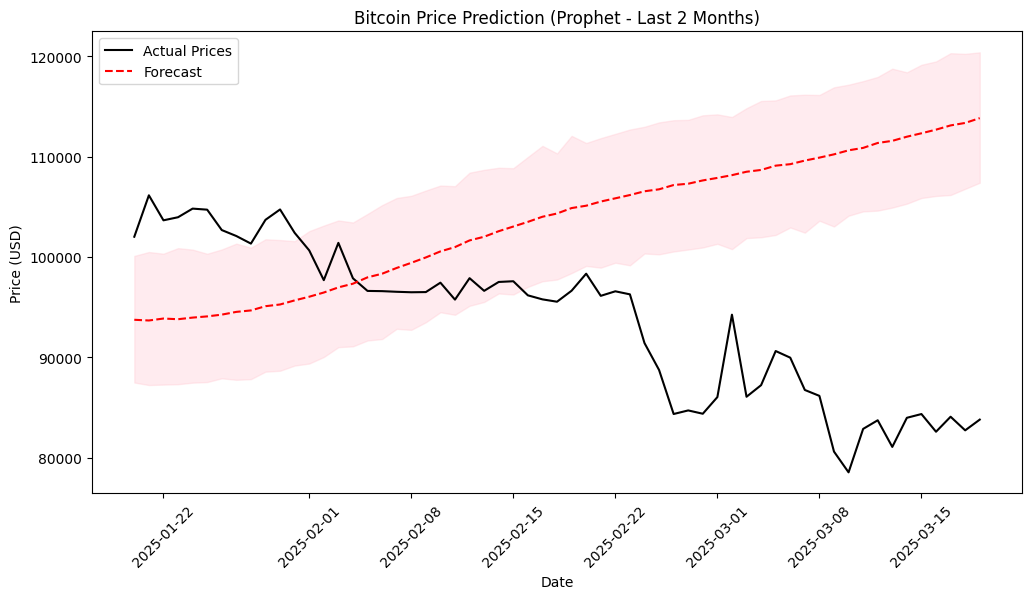

In [10]:
# Plot actual vs forecast
plt.figure(figsize=(12,6))
plt.plot(test_data["ds"], test_data["y"], label="Actual Prices", color='black')
plt.plot(forecast_df["ds"], forecast_df["Forecast"], label="Forecast", color='red', linestyle='dashed')
plt.fill_between(forecast_df["ds"], forecast_df["Lower Bound"], forecast_df["Upper Bound"], color='pink', alpha=0.3)
plt.legend()
plt.title("Bitcoin Price Prediction (Prophet - Last 2 Months)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.xticks(rotation=45)
plt.show()

### Model Evaluation

In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate evaluation metrics
mae = mean_absolute_error(test_data["y"], forecast_df["Forecast"])
rmse = np.sqrt(mean_squared_error(test_data["y"], forecast_df["Forecast"]))
r2 = r2_score(test_data["y"], forecast_df["Forecast"])

# Print results
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 13862.20
Root Mean Squared Error (RMSE): 16943.50
R² Score: -3.8824


### Preprocess the Data

Prophet expects a dataframe with two columns:

- ds: The date column (datetime format).
- y: The target variable (values to forecast).

In [ ]:
# Prepare dataframe for Prophet
df = df.reset_index()[['Date', 'Close']]
df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)

In [ ]:
df

,ds,y
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3802,2025-02-13,96623.867188
3803,2025-02-14,97508.968750
3804,2025-02-15,97580.351562
3805,2025-02-16,96175.031250


### Train Prophet Model

In [ ]:
model = Prophet()  # Initialize model
model.fit(df)  # Train on full data

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/la04wszk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/lar9nz42.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74284', 'data', 'file=/tmp/tmpe_5_03oe/la04wszk.json', 'init=/tmp/tmpe_5_03oe/lar9nz42.json', 'output', 'file=/tmp/tmpe_5_03oe/prophet_modelz8_1qlh2/prophet_model-20250213094150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:41:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:41:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


### Make Future Predictions

In [ ]:
future = model.make_future_dataframe(periods=365)  # Predict next 1 year
forecast = model.predict(future)

In [ ]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
4163,2026-02-09,127967.554554,115582.219389,141646.441053
4164,2026-02-10,128094.606718,115233.365065,142322.572714
4165,2026-02-11,128347.998866,114965.581032,141873.781193
4166,2026-02-12,128458.299280,115594.983011,142138.603512
4167,2026-02-13,128665.183381,115760.413966,142135.390075


### Visualize Predictions

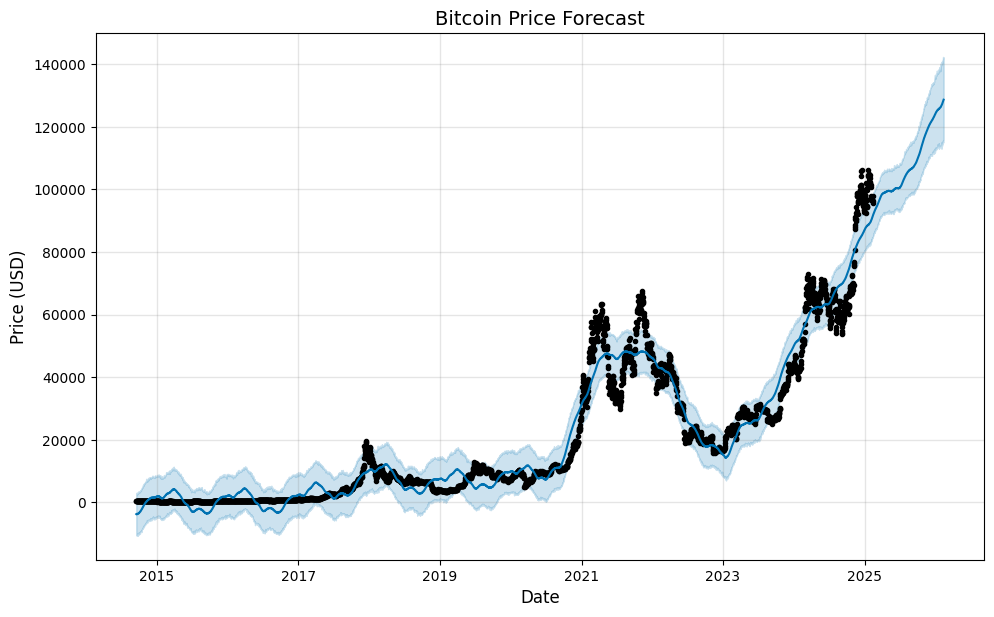

In [ ]:
fig = model.plot(forecast)
ax = fig.gca()  # Get current axis

ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Price (USD)", fontsize=12)
ax.set_title("Bitcoin Price Forecast", fontsize=14)

plt.show()

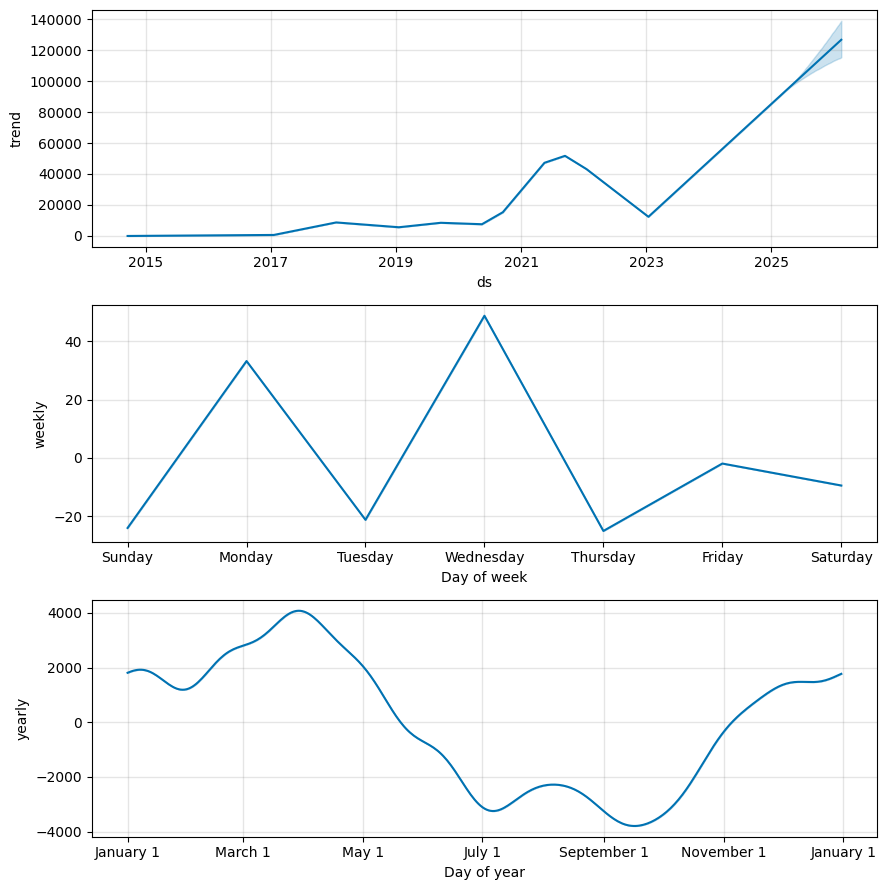

In [ ]:
fig2 = model.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(model, forecast)

## Model Evaluation

### Cross-Validation

In [ ]:
# 'initial' specifies the minimum training period, and 'horizon' is how far ahead you forecast.
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='90 days')

INFO:prophet:Making 17 forecasts with cutoffs between 2016-12-27 00:00:00 and 2024-11-15 00:00:00


  0%|          | 0/17 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/slm7tvtv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/o7bcxjzc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51861', 'data', 'file=/tmp/tmpe_5_03oe/slm7tvtv.json', 'init=/tmp/tmpe_5_03oe/o7bcxjzc.json', 'output', 'file=/tmp/tmpe_5_03oe/prophet_modelr5gi56jp/prophet_model-20250213095910.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:59:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:59:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/j4ip_97f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpe_5_03oe/iwjwr3p0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-12-28,826.965240,796.337145,856.711440,975.921021,2016-12-27
1,2016-12-29,826.623279,795.033831,855.678986,973.497009,2016-12-27
2,2016-12-30,826.621097,794.967204,857.745420,961.237976,2016-12-27
3,2016-12-31,825.092755,793.594923,856.521133,963.742981,2016-12-27
4,2017-01-01,822.784789,790.976394,854.199195,998.325012,2016-12-27


### Performance Metrics

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,9 days,1.267117e+08,11256.630064,8331.789495,0.335152,0.291817,0.339262,0.130719
1,10 days,1.292505e+08,11368.838950,8441.532959,0.338600,0.287103,0.343772,0.124183
2,11 days,1.319424e+08,11486.618340,8555.300989,0.341178,0.284455,0.348569,0.137255
3,12 days,1.359257e+08,11658.719251,8686.713184,0.345226,0.284455,0.354159,0.137255
4,13 days,1.406236e+08,11858.482815,8829.185849,0.348473,0.280138,0.359106,0.143791


In [ ]:
# Calculate overall (average) performance metrics
overall_performance = df_p[['mae', 'rmse', 'mape']].mean()
print("Overall Performance Metrics:")
print(overall_performance)

Overall Performance Metrics:
mae     11342.160953
rmse    15621.586305
mape        0.429682
dtype: float64


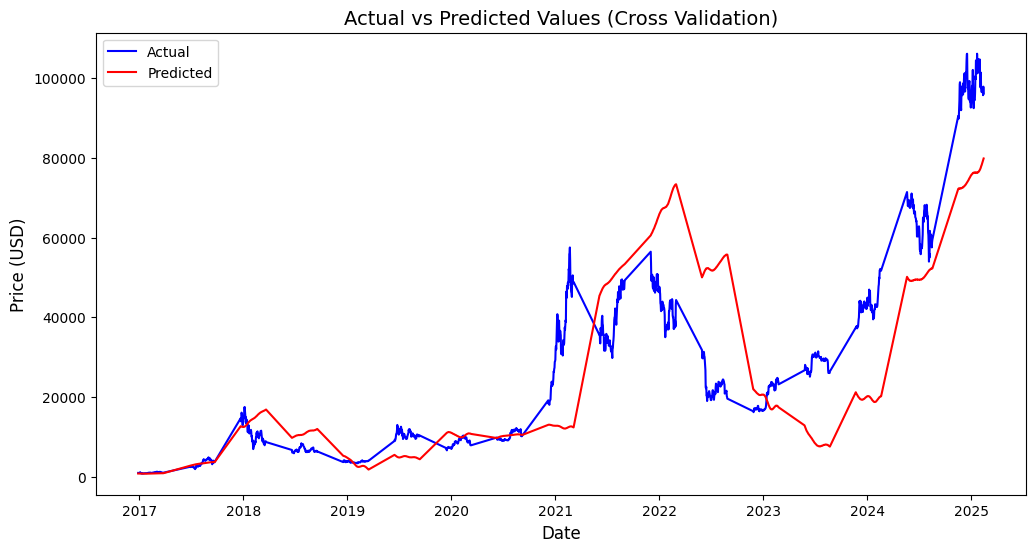

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(df_cv['ds'], df_cv['y'], 'b-', label='Actual')
plt.plot(df_cv['ds'], df_cv['yhat'], 'r-', label='Predicted')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.title("Actual vs Predicted Values (Cross Validation)", fontsize=14)
plt.legend()
plt.show()